### Importing Necessary Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn import metrics
import warnings

# Suppress warnings
warnings.filterwarnings('ignore')

### 1.1 Load the dataset

In [2]:
df = pd.read_csv('transactions.csv', index_col=0)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


### 1.2 Basic statistical properties of the "amount" column

In [3]:
print("Statistical Properties of 'amount' column:")
df['amount'].describe()

Statistical Properties of 'amount' column:


count    2.000000e+05
mean     1.808112e+05
std      3.291800e+05
min      3.200000e-01
25%      1.201612e+04
50%      6.872104e+04
75%      2.290791e+05
max      1.000000e+07
Name: amount, dtype: float64

### 1.3 Ratio of fraudulent to non-fraudulent transactions

In [4]:
fraud_ratio = df['isFraud'].value_counts(normalize=True)
print("\nFraud Transaction Ratio:")
print(fraud_ratio)
print(f"Fraudulent Transactions: {fraud_ratio[1]*100:.2f}%")
print(f"Non-Fraudulent Transactions: {fraud_ratio[0]*100:.2f}%")


Fraud Transaction Ratio:
isFraud
0    0.999265
1    0.000735
Name: proportion, dtype: float64
Fraudulent Transactions: 0.07%
Non-Fraudulent Transactions: 99.93%


### 1.4 a) Balance the dataset using sampling

In [5]:
# Similar to the original script, we'll use random sampling to balance classes
fraudulent = df[df['isFraud'] == 1]
non_fraudulent = df[df['isFraud'] == 0]

# Sample non-fraudulent transactions to match fraudulent transactions
sampled_non_fraudulent = non_fraudulent.sample(n=len(fraudulent), random_state=42)

# Combine the datasets
balanced_df = pd.concat([fraudulent, sampled_non_fraudulent]).reset_index(drop=True)

In [6]:
fraud_ratio = balanced_df['isFraud'].value_counts(normalize=True)
print("\nFraud Transaction Ratio:")
print(fraud_ratio)
print(f"Fraudulent Transactions: {fraud_ratio[1]*100:.2f}%")
print(f"Non-Fraudulent Transactions: {fraud_ratio[0]*100:.2f}%")


Fraud Transaction Ratio:
isFraud
1    0.5
0    0.5
Name: proportion, dtype: float64
Fraudulent Transactions: 50.00%
Non-Fraudulent Transactions: 50.00%


### 1.4 b) Correlation Heatmap

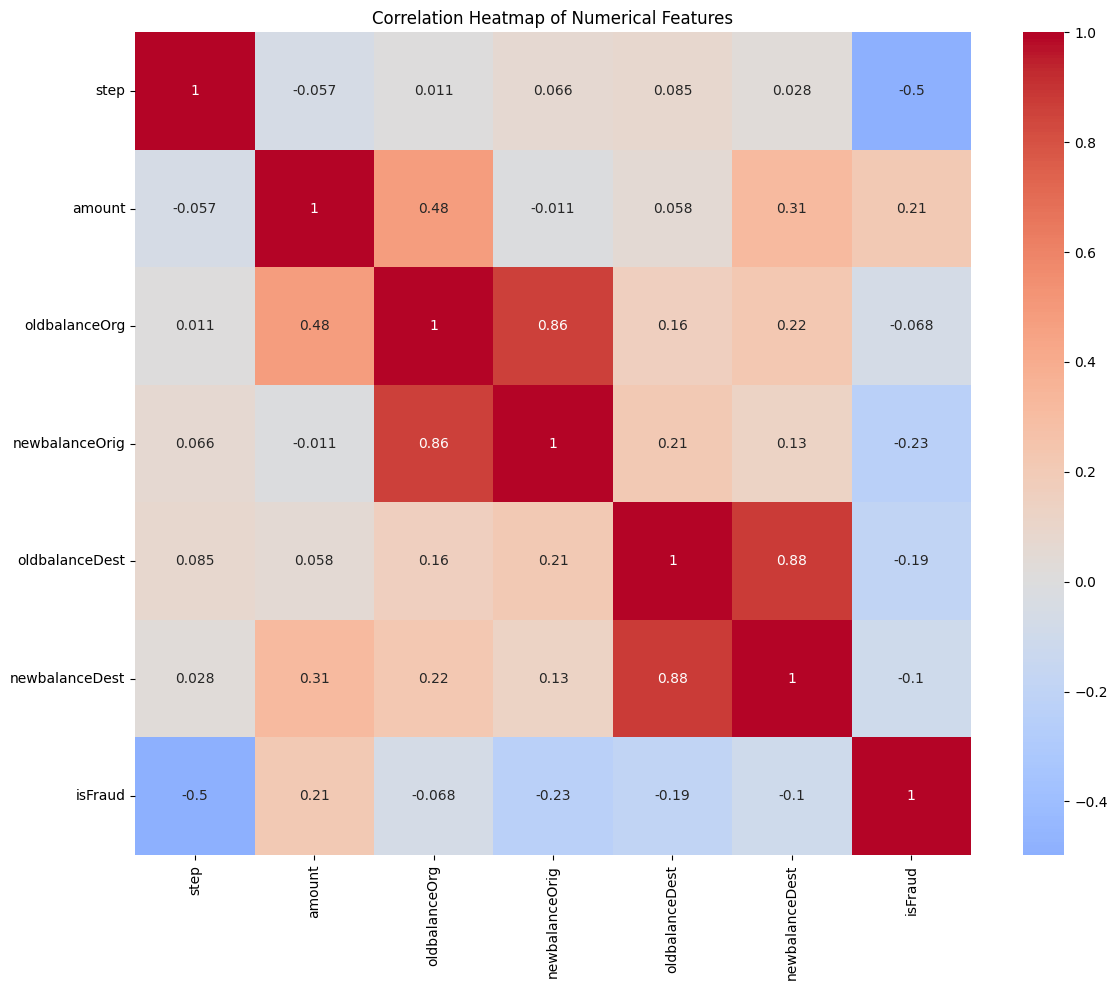

In [7]:
plt.figure(figsize=(12, 10))
correlation_matrix = balanced_df.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()

### 1.5 Pair Plot

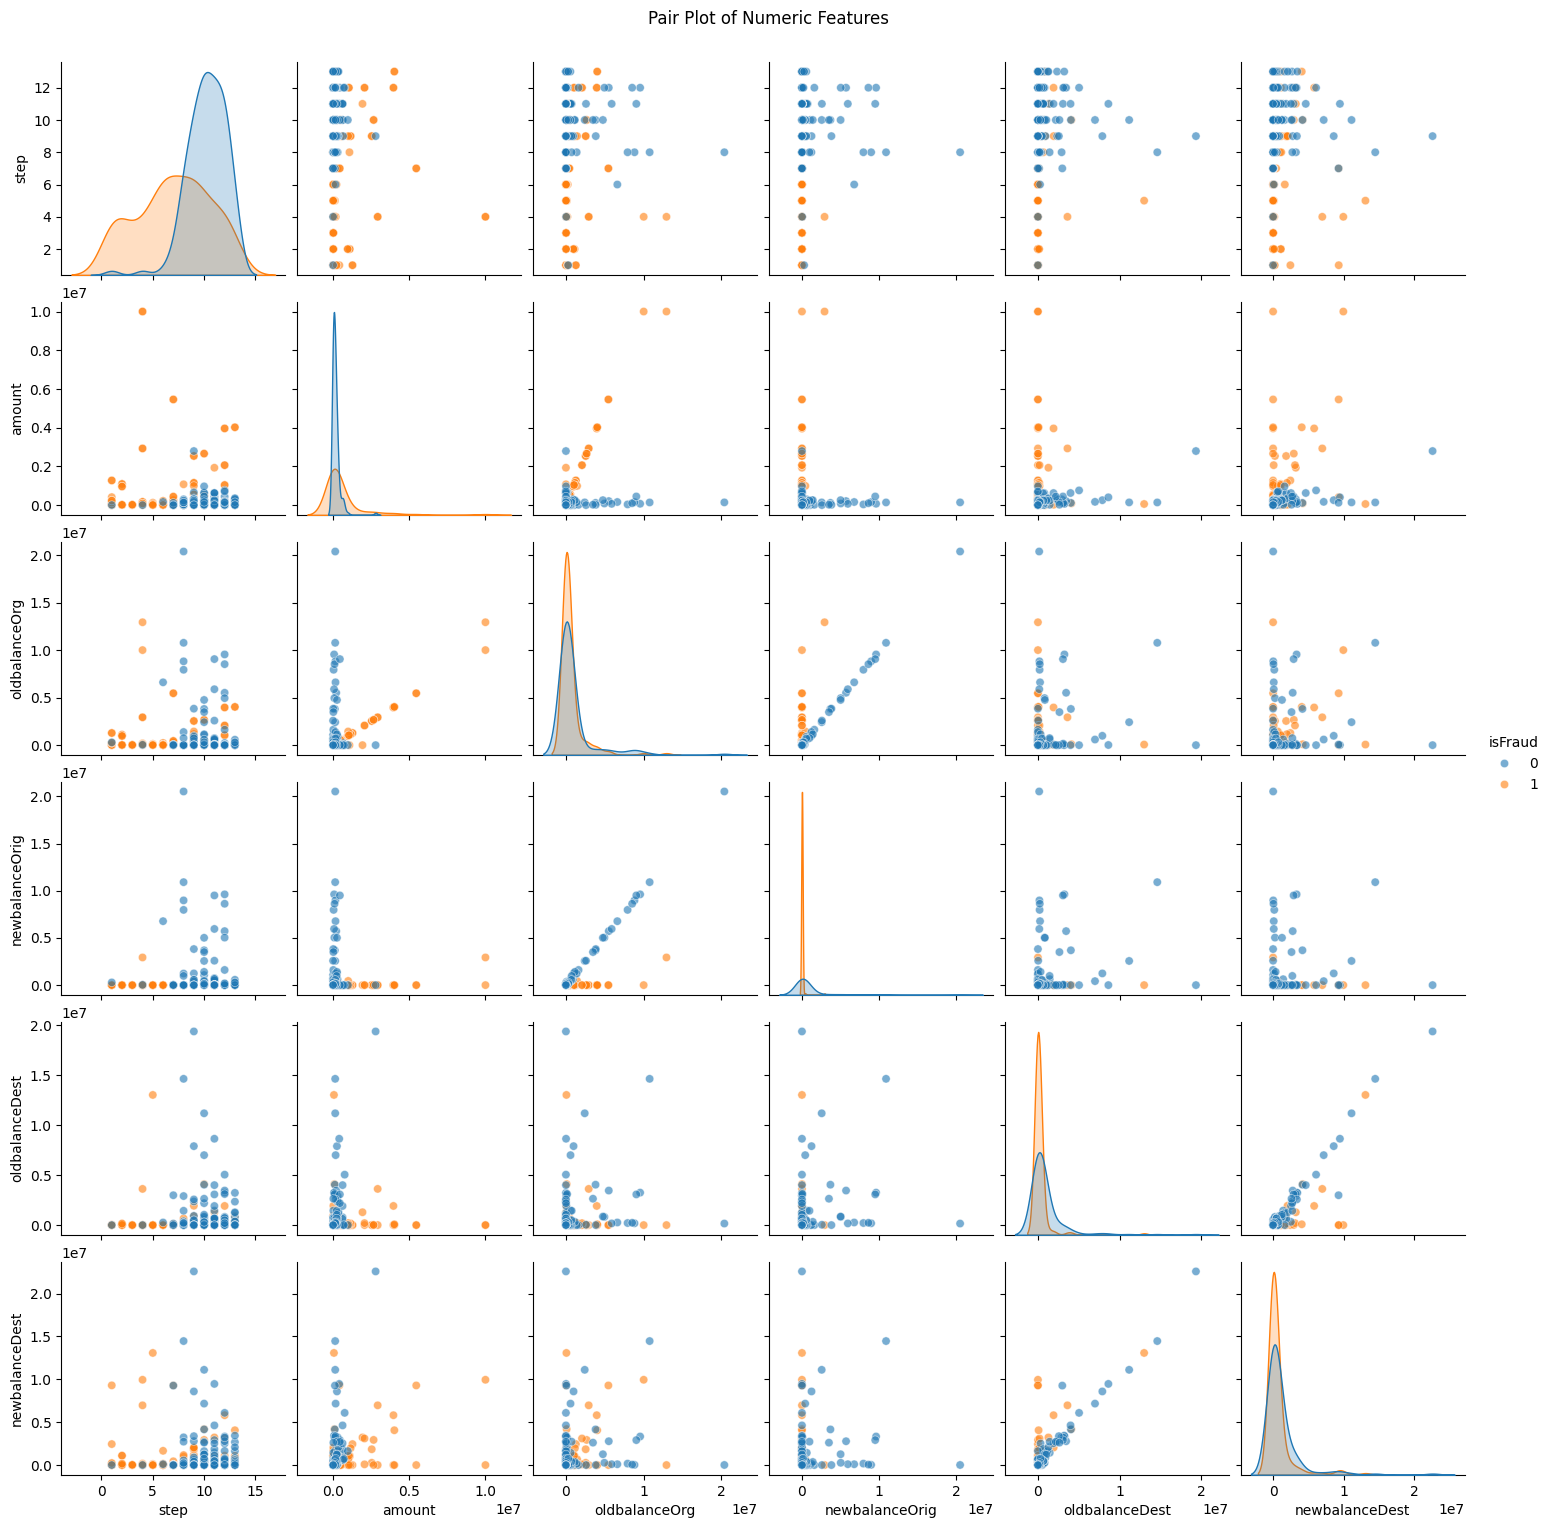

In [8]:
# Select numeric columns for pair plot
numeric_columns = balanced_df.select_dtypes(include=[np.number]).columns
sns.pairplot(balanced_df[numeric_columns], hue='isFraud', plot_kws={'alpha': 0.6})
plt.suptitle('Pair Plot of Numeric Features', y=1.02)
plt.show()

### 1.6 Create new features

In [9]:
# Extract hour from step (assuming step represents time)
balanced_df['hour'] = balanced_df['step'] % 24

# Create a feature for transaction amount category
balanced_df['amount_category'] = pd.cut(balanced_df['amount'], 
    bins=[0, 100, 500, 1000, float('inf')], 
    labels=['Small', 'Medium', 'Large', 'Very Large'])

balanced_df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,hour,amount_category
0,1,TRANSFER,181.0,C1305486145,181.0,0.0,C553264065,0.0,0.0,1,1,Medium
1,1,CASH_OUT,181.0,C840083671,181.0,0.0,C38997010,21182.0,0.0,1,1,Medium
2,1,TRANSFER,2806.0,C1420196421,2806.0,0.0,C972765878,0.0,0.0,1,1,Very Large
3,1,CASH_OUT,2806.0,C2101527076,2806.0,0.0,C1007251739,26202.0,0.0,1,1,Very Large
4,1,TRANSFER,20128.0,C137533655,20128.0,0.0,C1848415041,0.0,0.0,1,1,Very Large


### 1.7 Encode categorical attributes

In [10]:
# One-hot encoding for categorical variables
categorical_columns = ['type', 'amount_category']
features = pd.get_dummies(balanced_df, columns=categorical_columns)

# Prepare features and target
# Select relevant features for classification
feature_columns = [
    'step', 'amount', 'oldbalanceOrg', 'newbalanceOrig', 
    'oldbalanceDest', 'newbalanceDest', 'hour'
]
# Add one-hot encoded columns
feature_columns.extend([col for col in features.columns if col.startswith(tuple(categorical_columns))])

### 1.8 Split the data and create Decision Tree Classifier

In [11]:
# Prepare X and y
X = features[feature_columns]
y = features['isFraud']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and train the decision tree
dt_clf = DecisionTreeClassifier(random_state=42)
dt_clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

### 1.9 Predict and get performance metrics


In [13]:
y_pred = dt_clf.predict(X_test)
print("Decision Tree Classifier Accuracy: ", metrics.accuracy_score(y_test, y_pred))
print("\nClassification Report:")
print(metrics.classification_report(y_test, y_pred))

Decision Tree Classifier Accuracy:  0.9438202247191011

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.87      0.93        39
           1       0.91      1.00      0.95        50

    accuracy                           0.94        89
   macro avg       0.95      0.94      0.94        89
weighted avg       0.95      0.94      0.94        89



### 1.10 Feature Importance

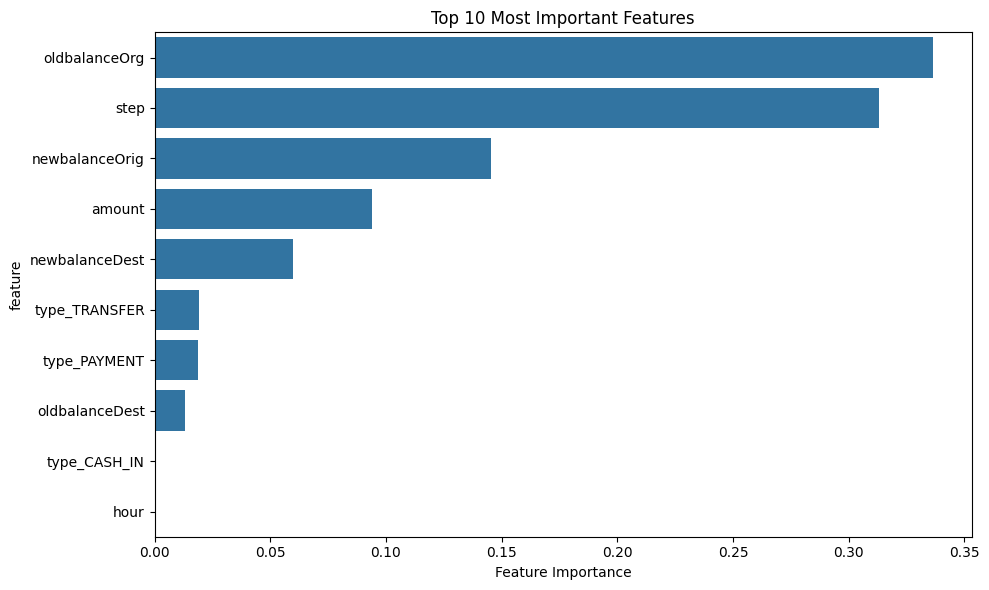


Top 5 Most Important Features:
          feature  importance
2   oldbalanceOrg    0.336490
0            step    0.313144
3  newbalanceOrig    0.145341
1          amount    0.094137
5  newbalanceDest    0.059857


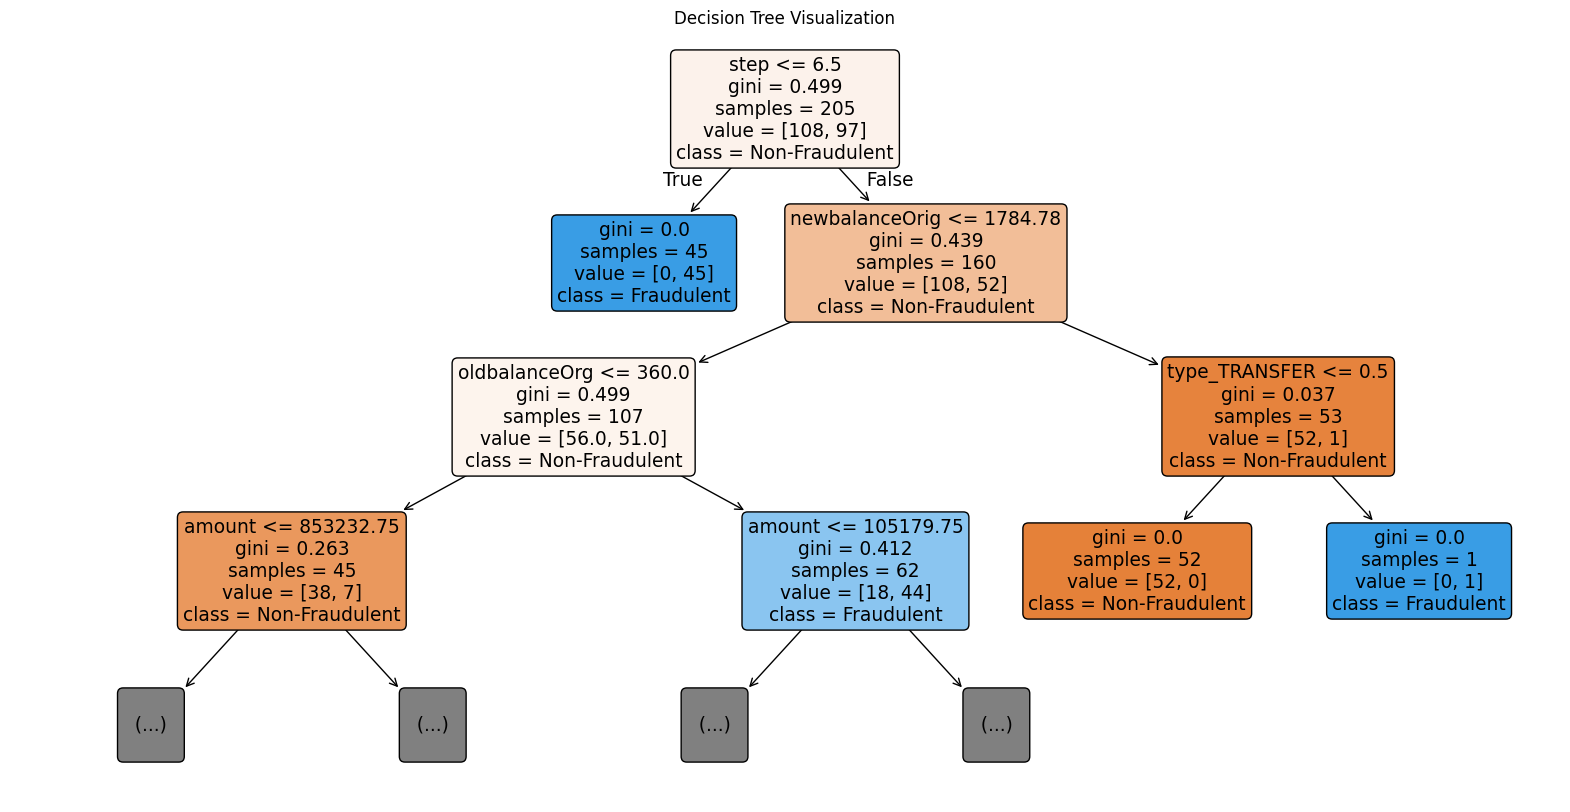

In [14]:
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': dt_clf.feature_importances_
}).sort_values('importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='importance', y='feature', data=feature_importance.head(10))
plt.title('Top 10 Most Important Features')
plt.xlabel('Feature Importance')
plt.tight_layout()
plt.show()

# Print top 5 most important features
print("\nTop 5 Most Important Features:")
print(feature_importance.head())

# Visualize the decision tree (limited depth for readability)
plt.figure(figsize=(20,10))
plot_tree(dt_clf, max_depth=3, feature_names=X.columns, 
          class_names=['Non-Fraudulent', 'Fraudulent'], 
          filled=True, rounded=True)
plt.title('Decision Tree Visualization')
plt.show()